In [1]:
from itertools import count
from collections import namedtuple

import gym
import gym_rags
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [2]:
seed = 543
gamma = 0.98
render = True
log_interval = 1
num_of_nodes = 5
env = gym.make('RAGS-v0', start_size=num_of_nodes, max_size=num_of_nodes, red_clique=3, blue_clique=3)
max_edges = num_of_nodes * (num_of_nodes - 1) // 2
buffer_size = max_edges * 2
print(max_edges, buffer_size)
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

2022-03-19 13:19:35,377 - root - INFO - RAGSEnv - Version 0.0.1
10 20


In [3]:
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(max_edges, max_edges*32)

        # actor's layer
        self.action_head = nn.Linear(max_edges * 32, buffer_size)

        # critic's layer
        self.value_head = nn.Linear(max_edges * 32, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))

        # actor: choses action to take from state s_t 
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t 
        return action_prob, state_values


model = Policy()
optimizer = optim.Adam(model.parameters(), lr=3e-2)
eps = np.finfo(np.float32).eps.item()


def select_action(state):
    state = np.asarray(state)
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)

    # and sample an action using the distribution
    action = m.sample()

    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    # the action to take (left or right)
    return action.item()


def finish_episode():
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss 
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]

In [4]:
from tqdm import tqdm

def main():
    running_reward = 1
    stop_on_done = True
    # run inifinitely many episodes
    for i_episode in count(1):

        # reset environment and episode reward
        obs, info = env.reset()
        ep_reward = 0

        # for each episode, only run 9999 steps so that we don't 
        # infinite loop while learning
        for t in tqdm(range(1, buffer_size * buffer_size)):

            # select action from policy
            action = select_action(obs['universe'])
            edge = (action + 1) % max_edges
            color = (action + 1) // max_edges
            state, reward, done, _ = env.step((edge, color))
            if done:
                env.render()

            model.rewards.append(reward)
            ep_reward += reward
            if done:
                break

        # perform backprop
        finish_episode()

        # update cumulative reward
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        
        if stop_on_done and done:
            break
        # log results
        if i_episode % log_interval == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))

        if reward > buffer_size:
            print("Solved! reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
            break

100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.16it/s]


Episode 1	Last reward: -183.00	Average reward: -8.20


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1595.94it/s]


Episode 2	Last reward: -17.00	Average reward: -8.64


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1595.94it/s]


Episode 3	Last reward: -15.00	Average reward: -8.96


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1701.02it/s]


Episode 4	Last reward: -26.00	Average reward: -9.81


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1702.38it/s]


Episode 5	Last reward: -14.00	Average reward: -10.02


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1823.94it/s]


Episode 6	Last reward: -8.00	Average reward: -9.92


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1596.00it/s]


Episode 7	Last reward: -7.00	Average reward: -9.77


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1319.64it/s]


Episode 8	Last reward: 3.00	Average reward: -9.13


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1596.00it/s]


Episode 9	Last reward: 4.00	Average reward: -8.48


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1596.02it/s]


Episode 10	Last reward: 4.00	Average reward: -7.85


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1418.69it/s]


Episode 11	Last reward: 6.00	Average reward: -7.16


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1964.39it/s]


Episode 12	Last reward: 5.00	Average reward: -6.55


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1418.68it/s]


Episode 13	Last reward: 3.00	Average reward: -6.08


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1702.49it/s]


Episode 14	Last reward: 5.00	Average reward: -5.52


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1595.99it/s]


Episode 15	Last reward: 3.00	Average reward: -5.10


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1418.64it/s]


Episode 16	Last reward: 4.00	Average reward: -4.64


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1595.95it/s]


Episode 17	Last reward: 6.00	Average reward: -4.11


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1702.17it/s]


Episode 18	Last reward: 4.00	Average reward: -3.70


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1418.61it/s]


Episode 19	Last reward: 4.00	Average reward: -3.32


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1595.33it/s]


Episode 20	Last reward: 3.00	Average reward: -3.00


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1110.24it/s]


Episode 21	Last reward: -3.00	Average reward: -3.00


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.11it/s]


Episode 22	Last reward: 4.00	Average reward: -2.65


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1595.92it/s]


Episode 23	Last reward: 6.00	Average reward: -2.22


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1823.98it/s]


Episode 24	Last reward: -5.00	Average reward: -2.36


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1596.01it/s]


Episode 25	Last reward: -4.00	Average reward: -2.44


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1702.41it/s]


Episode 26	Last reward: 7.00	Average reward: -1.97


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1596.05it/s]


Episode 27	Last reward: 6.00	Average reward: -1.57


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1702.47it/s]


Episode 28	Last reward: 7.00	Average reward: -1.14


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1596.02it/s]


Episode 29	Last reward: -2.00	Average reward: -1.18


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1595.98it/s]


Episode 30	Last reward: 7.00	Average reward: -0.78


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1702.46it/s]


Episode 31	Last reward: 6.00	Average reward: -0.44


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1702.46it/s]


Episode 32	Last reward: 7.00	Average reward: -0.06


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1702.37it/s]


Episode 33	Last reward: 9.00	Average reward: 0.39


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1343.94it/s]


Episode 34	Last reward: 5.00	Average reward: 0.62


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1702.47it/s]


Episode 35	Last reward: 6.00	Average reward: 0.89


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1702.69it/s]


Episode 36	Last reward: 8.00	Average reward: 1.24


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1702.28it/s]


Episode 37	Last reward: 5.00	Average reward: 1.43


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1596.03it/s]


Episode 38	Last reward: 7.00	Average reward: 1.71


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1460.41it/s]


Episode 39	Last reward: 5.00	Average reward: 1.87


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1418.72it/s]


Episode 40	Last reward: -3.00	Average reward: 1.63


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.16it/s]


Episode 41	Last reward: 4.00	Average reward: 1.75


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.07it/s]


Episode 42	Last reward: 4.00	Average reward: 1.86


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.17it/s]


Episode 43	Last reward: 8.00	Average reward: 2.17


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.09it/s]


Episode 44	Last reward: 8.00	Average reward: 2.46


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1595.92it/s]


Episode 45	Last reward: 2.00	Average reward: 2.44


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1595.98it/s]


Episode 46	Last reward: -43.00	Average reward: 0.17


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1344.02it/s]


Episode 47	Last reward: -35.00	Average reward: -1.59


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1418.66it/s]


Episode 48	Last reward: -42.00	Average reward: -3.61


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.08it/s]


Episode 49	Last reward: -46.00	Average reward: -5.73


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.06it/s]


Episode 50	Last reward: -14.00	Average reward: -6.15


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1595.93it/s]


Episode 51	Last reward: -12.00	Average reward: -6.44


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1499.20it/s]


Episode 52	Last reward: -14.00	Average reward: -6.82


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1594.98it/s]


Episode 53	Last reward: -5.00	Average reward: -6.73


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.10it/s]


Episode 54	Last reward: -14.00	Average reward: -7.09


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.06it/s]


Episode 55	Last reward: -5.00	Average reward: -6.99


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.11it/s]


Episode 56	Last reward: -3.00	Average reward: -6.79


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1501.97it/s]


Episode 57	Last reward: 5.00	Average reward: -6.20


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1596.06it/s]


Episode 58	Last reward: -2.00	Average reward: -5.99


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1596.02it/s]


Episode 59	Last reward: 8.00	Average reward: -5.29


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1702.44it/s]


Episode 60	Last reward: 4.00	Average reward: -4.82


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1276.77it/s]


Episode 61	Last reward: 6.00	Average reward: -4.28


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.10it/s]


Episode 62	Last reward: 5.00	Average reward: -3.82


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1595.74it/s]


Episode 63	Last reward: 5.00	Average reward: -3.38


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.11it/s]


Episode 64	Last reward: 6.00	Average reward: -2.91


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1596.02it/s]


Episode 65	Last reward: 5.00	Average reward: -2.51


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1702.27it/s]


Episode 66	Last reward: 5.00	Average reward: -2.14


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1702.41it/s]


Episode 67	Last reward: 7.00	Average reward: -1.68


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1501.99it/s]


Episode 68	Last reward: 8.00	Average reward: -1.20


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1702.40it/s]


Episode 69	Last reward: 6.00	Average reward: -0.84


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1595.96it/s]


Episode 70	Last reward: 7.00	Average reward: -0.44


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1596.08it/s]


Episode 71	Last reward: 8.00	Average reward: -0.02


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1501.34it/s]


Episode 72	Last reward: 6.00	Average reward: 0.28


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1595.99it/s]


Episode 73	Last reward: 5.00	Average reward: 0.51


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1593.30it/s]


Episode 74	Last reward: 8.00	Average reward: 0.89


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1418.71it/s]


Episode 75	Last reward: 7.00	Average reward: 1.19


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.04it/s]


Episode 76	Last reward: 6.00	Average reward: 1.43


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1702.34it/s]


Episode 77	Last reward: 9.00	Average reward: 1.81


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1595.98it/s]


Episode 78	Last reward: 6.00	Average reward: 2.02


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1595.95it/s]


Episode 79	Last reward: 5.00	Average reward: 2.17


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1596.01it/s]


Episode 80	Last reward: 8.00	Average reward: 2.46


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1595.98it/s]


Episode 81	Last reward: 3.00	Average reward: 2.49


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.10it/s]


Episode 82	Last reward: -4.00	Average reward: 2.17


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.11it/s]


Episode 83	Last reward: -16.00	Average reward: 1.26


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1596.01it/s]


Episode 84	Last reward: 8.00	Average reward: 1.59


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1596.02it/s]


Episode 85	Last reward: 6.00	Average reward: 1.81


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.08it/s]


Episode 86	Last reward: -6.00	Average reward: 1.42


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1418.65it/s]


Episode 87	Last reward: -4.00	Average reward: 1.15


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.16it/s]


Episode 88	Last reward: -13.00	Average reward: 0.44


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1499.42it/s]


Episode 89	Last reward: -13.00	Average reward: -0.23


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.06it/s]


Episode 90	Last reward: -12.00	Average reward: -0.82


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1418.72it/s]


Episode 91	Last reward: -3.00	Average reward: -0.93


100%|██████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1502.03it/s]


Episode 92	Last reward: -32.00	Average reward: -2.48


  0%|                                                                                          | 0/399 [00:00<?, ?it/s]

2022-03-19 13:20:18,152 - matplotlib - DEBUG - matplotlib data path: C:\Users\Priya\anaconda3\lib\site-packages\matplotlib\mpl-data
2022-03-19 13:20:18,167 - matplotlib - DEBUG - CONFIGDIR=C:\Users\Priya\.matplotlib
2022-03-19 13:20:18,183 - matplotlib - DEBUG - matplotlib version 3.4.3
2022-03-19 13:20:18,183 - matplotlib - DEBUG - interactive is False
2022-03-19 13:20:18,183 - matplotlib - DEBUG - platform is win32
2022-03-19 13:20:18,183 - matplotlib - DEBUG - loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'nt', 'winreg', '_frozen_importlib_external', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', 'encodings.cp1252', '_signal', 'encodings.latin_1', '_abc', 'abc', 'io', '__main__', '_stat', 'stat', '_collections_abc', 'genericpath', 'ntpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external',

2022-03-19 13:20:18,230 - matplotlib - DEBUG - CACHEDIR=C:\Users\Priya\.matplotlib
2022-03-19 13:20:18,246 - matplotlib.font_manager - DEBUG - Using fontManager instance from C:\Users\Priya\.matplotlib\fontlist-v330.json
2022-03-19 13:20:18,496 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2022-03-19 13:20:18,511 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.


  8%|██████▋                                                                          | 33/399 [00:00<00:06, 52.77it/s]

2022-03-19 13:20:18,621 - matplotlib.axes._base - DEBUG - top of axes not in the figure, so title not moved
2022-03-19 13:20:18,636 - matplotlib.axes._base - DEBUG - top of axes not in the figure, so title not moved
2022-03-19 13:20:18,652 - matplotlib.axes._base - DEBUG - top of axes not in the figure, so title not moved
2022-03-19 13:20:18,667 - matplotlib.axes._base - DEBUG - top of axes not in the figure, so title not moved


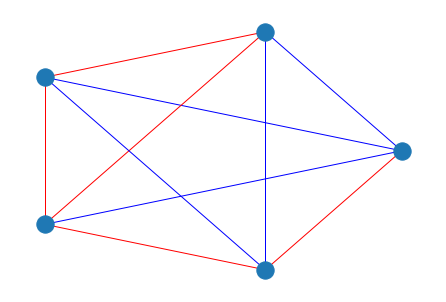

In [5]:
import logging.config
logging.config.dictConfig({
    'version': 1,
    'disable_existing_loggers': True,
})

model = Policy()
optimizer = optim.Adam(model.parameters(), lr=3e-2)
eps = np.finfo(np.float32).eps.item()
env.reset()
main()